In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import glob
import geopandas as gp
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['figure.facecolor']='w'
import warnings
warnings.filterwarnings('ignore')

In [2]:
drop_columns = ['commarea','countyfp10', 'name10',
       'namelsad10', 'notes', 'statefp10', 'tractce10']

In [3]:
chicago_shp = '../data_misc/chicago_shapefile/geo_export_2702d908-a4db-4dc5-a4de-78a5f3f67445.shp'
chicago_shp = '../data_misc/chicago_shapefile/geo_export_ec346dbb-8c11-44b4-be04-0301ae3f9c64.shp'
chicago = gp.read_file(chicago_shp)
chicago.drop(columns=drop_columns, inplace=True)
chicago.geoid10 = chicago.geoid10.apply(np.int64)
chicago

,commarea_n,geoid10,geometry
0,44.0,17031842400,"POLYGON ((-87.62405 41.73022, -87.62405 41.730..."
1,59.0,17031840300,"POLYGON ((-87.68608 41.82296, -87.68607 41.823..."
2,34.0,17031841100,"POLYGON ((-87.62935 41.85280, -87.62934 41.852..."
3,31.0,17031841200,"POLYGON ((-87.68813 41.85569, -87.68816 41.856..."
4,32.0,17031839000,"POLYGON ((-87.63312 41.87449, -87.63306 41.874..."
...,...,...,...
796,7.0,17031070400,"POLYGON ((-87.65746 41.93258, -87.65722 41.932..."
797,7.0,17031070500,"POLYGON ((-87.66349 41.93036, -87.66350 41.930..."
798,13.0,17031130300,"POLYGON ((-87.71436 41.98300, -87.71472 41.982..."
799,29.0,17031292200,"POLYGON ((-87.71317 41.85523, -87.71357 41.855..."


In [6]:
pct_park = parkjoin[['geoid10','tract_area', 'park_area']]
pct_park.geoid10 = pct_park.geoid10.apply(np.int64)
pct_park['pct_park'] = np.divide(pct_park['park_area'],pct_park['tract_area'])
pct_park = pct_park.groupby('geoid10').sum().reset_index()

NameError: name 'parkjoin' is not defined

In [5]:
chicago.merge(pct_park[['pct_park', 'geoid10']], on='geoid10', how='left')

NameError: name 'pct_park' is not defined

In [7]:
# merging chicago and park area
print('Merging Chicago shapefile and park area')
len_before = len(chicago)
n_cols_before = len(chicago.columns)
chicago = chicago.merge(pct_park[['pct_park','geoid10']], on='geoid10', how='left')
len_after = len(chicago)
n_cols_after = len(chicago.columns)
print(f'Expecting {len_before} rows, got {len_after} rows.')
print(f'Expecting {n_cols_before+1} columns {n_cols_after}\n')

Merging Chicago shapefile and park area
Expecting 801 rows, got 801 rows.
Expecting 5 columns 5



In [8]:
chicago['pct_park'].fillna(0, inplace=True)

In [9]:
chicago.isnull().sum()

commarea_n    0
geoid10       0
geometry      0
tract_area    0
pct_park      0
dtype: int64

In [10]:
churches = gp.read_file('kx-chicago-illinois-churches-SHP/chicago-illinois-churches.shp')
parks = gp.read_file('kx-chicago-illinois-parks-SHP/chicago-illinois-parks.shp')
schools = gp.read_file('kx-chicago-illinois-schools-SHP/chicago-illinois-schools.shp')
libraries = gp.read_file('kx-chicago-illinois-libraries-SHP/chicago-illinois-libraries.shp')

In [11]:
churches.to_crs({'init': 'epsg:4326'},inplace=True) 
parks.to_crs({'init': 'epsg:4326'},inplace=True) 
libraries.to_crs({'init': 'epsg:4326'},inplace=True) 
schools.to_crs({'init': 'epsg:4326'},inplace=True) 

In [12]:
private = schools[schools.TYPE=='PRIVATE']
public = schools[schools.TYPE=='CPS']

In [13]:
churches['n_churches'] = 1
libraries['n_libraries'] = 1
private['n_private'] = 1
public['n_public'] = 1

In [14]:
chi_copy = chicago.copy()
chi_copy = chi_copy.to_crs(epsg=6933)
print(chi_copy.crs)
chi_copy['area'] = chi_copy.geometry.area/1e6
chi_copy.head(2)
chicago['tract_area'] = chi_copy['area']

epsg:6933


In [15]:
parkjoin = gp.overlay(chicago, parks[['geometry']], how='intersection')

In [16]:
parks_copy = parkjoin.copy()
parks_copy = parks_copy.to_crs(epsg=6933)
print(parks_copy.crs)
parks_copy['park_area'] = parks_copy.geometry.area/1e6
parks_copy
parkjoin['park_area'] = parks_copy['park_area']

epsg:6933


In [17]:
parkjoin.head(3)

,commarea_n,geoid10,tract_area,pct_park,geometry,park_area
0,44.0,17031842400,1.968638,0.028370,"POLYGON ((-87.62943 41.74552, -87.62943 41.745...",0.055850
1,59.0,17031840300,0.831225,0.009803,"POLYGON ((-87.67888 41.83208, -87.67790 41.832...",0.008148
2,34.0,17031841100,1.143245,0.024508,"POLYGON ((-87.63356 41.84818, -87.63355 41.847...",0.001804


In [18]:
pct_park = parkjoin[['geoid10','tract_area', 'park_area']]
pct_park.geoid10 = pct_park.geoid10.apply(np.int64)
pct_park.set_index('geoid10', inplace=True)
pct_park.head(3)

,tract_area,park_area
geoid10,,
17031842400,1.968638,0.055850
17031840300,0.831225,0.008148
17031841100,1.143245,0.001804


In [22]:
publicjoin = gp.sjoin(chicago, public)
privatejoin = gp.sjoin(chicago, private)
librariesjoin = gp.sjoin(chicago, libraries)
churchesjoin = gp.sjoin(chicago, churches)

In [23]:
n_cps = publicjoin[['geoid10','n_public']].groupby('geoid10').sum()

In [24]:
n_private = privatejoin[['geoid10','n_private']].groupby('geoid10').sum()

In [25]:
n_libraries = librariesjoin[['geoid10','n_libraries']].groupby('geoid10').sum()

In [26]:
n_churches = churchesjoin[['geoid10','n_churches']].groupby('geoid10').sum()

In [27]:
chicago.set_index('geoid10', inplace=True)

In [29]:
chicago_buildings = pd.concat([chicago, n_churches, n_cps, n_libraries, n_private], axis=1)
chicago_buildings.fillna(0,inplace=True)

In [30]:
chicago_buildings.head(3)

,commarea_n,geometry,tract_area,pct_park,n_churches,n_public,n_libraries,n_private
geoid10,,,,,,,,
17031010100,1.0,"POLYGON ((-87.66368 42.01940, -87.66384 42.019...",0.381062,0.087695,2.0,1.0,0.0,1.0
17031010201,1.0,"POLYGON ((-87.68010 42.01254, -87.68027 42.012...",0.504471,0.075785,0.0,1.0,0.0,0.0
17031010202,1.0,"POLYGON ((-87.67336 42.01937, -87.67311 42.019...",0.351720,0.077060,0.0,1.0,0.0,0.0


In [31]:
chicago_buildings.index

Int64Index([17031010100, 17031010201, 17031010202, 17031010300, 17031010400,
            17031010501, 17031010502, 17031010503, 17031010600, 17031010701,
            ...
            17031843200, 17031843300, 17031843400, 17031843500, 17031843600,
            17031843700, 17031843800, 17031843900, 17031980000, 17031980100],
           dtype='int64', name='geoid10', length=801)

In [32]:
pct_park.index

Int64Index([17031842400, 17031840300, 17031841100, 17031841100, 17031330200,
            17031839000, 17031839000, 17031650301, 17031650301, 17031530503,
            ...
            17031281900, 17031550100, 17031071200, 17031611900, 17031620200,
            17031070200, 17031070400, 17031070500, 17031130300, 17031292200],
           dtype='int64', name='geoid10', length=657)

In [33]:
pct_park_sum = pct_park[['park_area']].groupby('geoid10').sum()

In [34]:
park_newidx = pct_park.reset_index()

In [35]:
with_parks = chicago_buildings.merge(pct_park_sum, how='left', on='geoid10')

In [36]:
with_parks

,commarea_n,geometry,tract_area,pct_park,n_churches,n_public,n_libraries,n_private,park_area
geoid10,,,,,,,,,
17031010100,1.0,"POLYGON ((-87.66368 42.01940, -87.66384 42.019...",0.381062,0.087695,2.0,1.0,0.0,1.0,0.033417
17031010201,1.0,"POLYGON ((-87.68010 42.01254, -87.68027 42.012...",0.504471,0.075785,0.0,1.0,0.0,0.0,0.038231
17031010202,1.0,"POLYGON ((-87.67336 42.01937, -87.67311 42.019...",0.351720,0.077060,0.0,1.0,0.0,0.0,0.027103
17031010300,1.0,"POLYGON ((-87.66506 42.01280, -87.66543 42.012...",0.472019,0.034183,3.0,0.0,0.0,0.0,0.016135
17031010400,1.0,"POLYGON ((-87.65080 41.99849, -87.65500 41.998...",1.151352,0.163661,0.0,0.0,0.0,0.0,0.188431
...,...,...,...,...,...,...,...,...,...
17031843700,5.0,"POLYGON ((-87.69667 41.94854, -87.69673 41.948...",1.263070,0.099576,0.0,2.0,0.0,0.0,0.125771
17031843800,61.0,"POLYGON ((-87.64516 41.79430, -87.64516 41.794...",1.309514,0.012040,10.0,2.0,0.0,1.0,0.015767
17031843900,42.0,"POLYGON ((-87.55869 41.77379, -87.56605 41.773...",2.211633,0.404850,2.0,0.0,0.0,1.0,0.895380


In [37]:
with_parks['park_area'].fillna(0,inplace=True)

In [38]:
with_parks.tract_area > with_parks.park_area

geoid10
17031010100    True
17031010201    True
17031010202    True
17031010300    True
17031010400    True
               ... 
17031843700    True
17031843800    True
17031843900    True
17031980000    True
17031980100    True
Length: 801, dtype: bool

In [39]:
with_parks['pct_park'] = np.divide(with_parks.park_area, with_parks.tract_area)

In [40]:
with_parks

,commarea_n,geometry,tract_area,pct_park,n_churches,n_public,n_libraries,n_private,park_area
geoid10,,,,,,,,,
17031010100,1.0,"POLYGON ((-87.66368 42.01940, -87.66384 42.019...",0.381062,0.087695,2.0,1.0,0.0,1.0,0.033417
17031010201,1.0,"POLYGON ((-87.68010 42.01254, -87.68027 42.012...",0.504471,0.075785,0.0,1.0,0.0,0.0,0.038231
17031010202,1.0,"POLYGON ((-87.67336 42.01937, -87.67311 42.019...",0.351720,0.077060,0.0,1.0,0.0,0.0,0.027103
17031010300,1.0,"POLYGON ((-87.66506 42.01280, -87.66543 42.012...",0.472019,0.034183,3.0,0.0,0.0,0.0,0.016135
17031010400,1.0,"POLYGON ((-87.65080 41.99849, -87.65500 41.998...",1.151352,0.163661,0.0,0.0,0.0,0.0,0.188431
...,...,...,...,...,...,...,...,...,...
17031843700,5.0,"POLYGON ((-87.69667 41.94854, -87.69673 41.948...",1.263070,0.099576,0.0,2.0,0.0,0.0,0.125771
17031843800,61.0,"POLYGON ((-87.64516 41.79430, -87.64516 41.794...",1.309514,0.012040,10.0,2.0,0.0,1.0,0.015767
17031843900,42.0,"POLYGON ((-87.55869 41.77379, -87.56605 41.773...",2.211633,0.404850,2.0,0.0,0.0,1.0,0.895380


<AxesSubplot:>

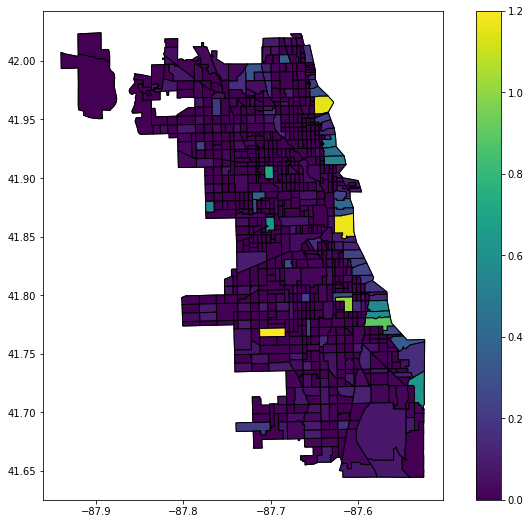

In [41]:
ax = chicago.plot(edgecolor='k', color='w')
with_parks.plot(ax = ax,column='park_area', edgecolor='k',legend=True)
# chicago_buildings.plot(ax = ax,column='n_libraries', legend=True, cmap='tab20b')

Text(0.5, 1.0, 'Percent Area covered by Park')

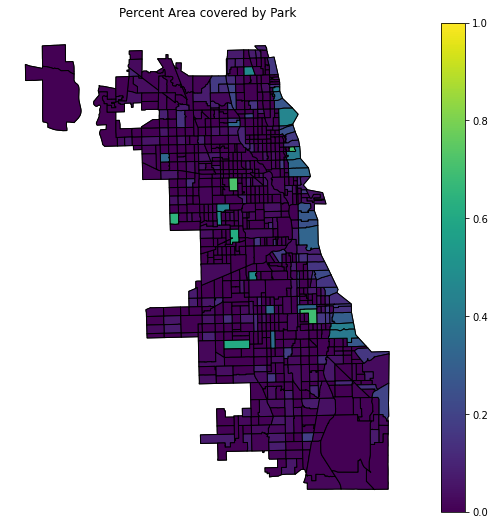

In [42]:
ax = chicago.plot(edgecolor='k', color='w')
with_parks.plot(ax = ax,column='pct_park', legend=True, edgecolor='k', vmax=1)
ax.set_axis_off()
ax.set_title('Percent Area covered by Park')

In [43]:
with_parks

,commarea_n,geometry,tract_area,pct_park,n_churches,n_public,n_libraries,n_private,park_area
geoid10,,,,,,,,,
17031010100,1.0,"POLYGON ((-87.66368 42.01940, -87.66384 42.019...",0.381062,0.087695,2.0,1.0,0.0,1.0,0.033417
17031010201,1.0,"POLYGON ((-87.68010 42.01254, -87.68027 42.012...",0.504471,0.075785,0.0,1.0,0.0,0.0,0.038231
17031010202,1.0,"POLYGON ((-87.67336 42.01937, -87.67311 42.019...",0.351720,0.077060,0.0,1.0,0.0,0.0,0.027103
17031010300,1.0,"POLYGON ((-87.66506 42.01280, -87.66543 42.012...",0.472019,0.034183,3.0,0.0,0.0,0.0,0.016135
17031010400,1.0,"POLYGON ((-87.65080 41.99849, -87.65500 41.998...",1.151352,0.163661,0.0,0.0,0.0,0.0,0.188431
...,...,...,...,...,...,...,...,...,...
17031843700,5.0,"POLYGON ((-87.69667 41.94854, -87.69673 41.948...",1.263070,0.099576,0.0,2.0,0.0,0.0,0.125771
17031843800,61.0,"POLYGON ((-87.64516 41.79430, -87.64516 41.794...",1.309514,0.012040,10.0,2.0,0.0,1.0,0.015767
17031843900,42.0,"POLYGON ((-87.55869 41.77379, -87.56605 41.773...",2.211633,0.404850,2.0,0.0,0.0,1.0,0.895380


In [44]:
chicago

,commarea_n,geometry,tract_area,pct_park
geoid10,,,,
17031842400,44.0,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",1.968638,0.028370
17031840300,59.0,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",0.831225,0.009803
17031841100,34.0,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",1.143245,0.024508
17031841200,31.0,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",0.625406,0.000000
17031839000,32.0,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",0.516456,0.022660
...,...,...,...,...
17031070400,7.0,"POLYGON ((-87.65746 41.93258, -87.65722 41.932...",0.324370,0.035574
17031070500,7.0,"POLYGON ((-87.66349 41.93036, -87.66350 41.930...",0.305416,0.004439
17031130300,13.0,"POLYGON ((-87.71436 41.98300, -87.71472 41.982...",0.721100,0.126030


In [45]:
chicago_buildings

,commarea_n,geometry,tract_area,pct_park,n_churches,n_public,n_libraries,n_private
geoid10,,,,,,,,
17031010100,1.0,"POLYGON ((-87.66368 42.01940, -87.66384 42.019...",0.381062,0.087695,2.0,1.0,0.0,1.0
17031010201,1.0,"POLYGON ((-87.68010 42.01254, -87.68027 42.012...",0.504471,0.075785,0.0,1.0,0.0,0.0
17031010202,1.0,"POLYGON ((-87.67336 42.01937, -87.67311 42.019...",0.351720,0.077060,0.0,1.0,0.0,0.0
17031010300,1.0,"POLYGON ((-87.66506 42.01280, -87.66543 42.012...",0.472019,0.034183,3.0,0.0,0.0,0.0
17031010400,1.0,"POLYGON ((-87.65080 41.99849, -87.65500 41.998...",1.151352,0.163661,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
17031843700,5.0,"POLYGON ((-87.69667 41.94854, -87.69673 41.948...",1.263070,0.099576,0.0,2.0,0.0,0.0
17031843800,61.0,"POLYGON ((-87.64516 41.79430, -87.64516 41.794...",1.309514,0.012040,10.0,2.0,0.0,1.0
17031843900,42.0,"POLYGON ((-87.55869 41.77379, -87.56605 41.773...",2.211633,0.404850,2.0,0.0,0.0,1.0


In [46]:
chicago.merge(chicago_buildings, on='geoid10',how='left')

,commarea_n_x,geometry_x,tract_area_x,pct_park_x,commarea_n_y,geometry_y,tract_area_y,pct_park_y,n_churches,n_public,n_libraries,n_private
geoid10,,,,,,,,,,,,
17031842400,44.0,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",1.968638,0.028370,44.0,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",1.968638,0.028370,3.0,3.0,0.0,0.0
17031840300,59.0,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",0.831225,0.009803,59.0,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",0.831225,0.009803,0.0,1.0,0.0,0.0
17031841100,34.0,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",1.143245,0.024508,34.0,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",1.143245,0.024508,2.0,1.0,1.0,2.0
17031841200,31.0,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",0.625406,0.000000,31.0,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",0.625406,0.000000,4.0,1.0,0.0,1.0
17031839000,32.0,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",0.516456,0.022660,32.0,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",0.516456,0.022660,1.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17031070400,7.0,"POLYGON ((-87.65746 41.93258, -87.65722 41.932...",0.324370,0.035574,7.0,"POLYGON ((-87.65746 41.93258, -87.65722 41.932...",0.324370,0.035574,4.0,0.0,1.0,0.0
17031070500,7.0,"POLYGON ((-87.66349 41.93036, -87.66350 41.930...",0.305416,0.004439,7.0,"POLYGON ((-87.66349 41.93036, -87.66350 41.930...",0.305416,0.004439,1.0,0.0,0.0,0.0
17031130300,13.0,"POLYGON ((-87.71436 41.98300, -87.71472 41.982...",0.721100,0.126030,13.0,"POLYGON ((-87.71436 41.98300, -87.71472 41.982...",0.721100,0.126030,11.0,0.0,0.0,1.0


In [47]:
with_parks[['tract_area',
            'n_churches',
            'n_public',
            'n_private',
            'pct_park',
            'n_libraries']]

,tract_area,n_churches,n_public,n_private,pct_park,n_libraries
geoid10,,,,,,
17031010100,0.381062,2.0,1.0,1.0,0.087695,0.0
17031010201,0.504471,0.0,1.0,0.0,0.075785,0.0
17031010202,0.351720,0.0,1.0,0.0,0.077060,0.0
17031010300,0.472019,3.0,0.0,0.0,0.034183,0.0
17031010400,1.151352,0.0,0.0,0.0,0.163661,0.0
...,...,...,...,...,...,...
17031843700,1.263070,0.0,2.0,0.0,0.099576,0.0
17031843800,1.309514,10.0,2.0,1.0,0.012040,0.0
17031843900,2.211633,2.0,0.0,1.0,0.404850,0.0


In [48]:
chicago.merge(with_parks[['tract_area',
                                    'n_churches',
                                    'n_public',
                                    'n_private',
                                    'pct_park',
                                    'n_libraries']],
                                    on='geoid10',
                                    how='left')

,commarea_n,geometry,tract_area_x,pct_park_x,tract_area_y,n_churches,n_public,n_private,pct_park_y,n_libraries
geoid10,,,,,,,,,,
17031842400,44.0,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",1.968638,0.028370,1.968638,3.0,3.0,0.0,0.028370,0.0
17031840300,59.0,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",0.831225,0.009803,0.831225,0.0,1.0,0.0,0.009803,0.0
17031841100,34.0,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",1.143245,0.024508,1.143245,2.0,1.0,2.0,0.024508,1.0
17031841200,31.0,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",0.625406,0.000000,0.625406,4.0,1.0,1.0,0.000000,0.0
17031839000,32.0,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",0.516456,0.022660,0.516456,1.0,1.0,2.0,0.022660,0.0
...,...,...,...,...,...,...,...,...,...,...
17031070400,7.0,"POLYGON ((-87.65746 41.93258, -87.65722 41.932...",0.324370,0.035574,0.324370,4.0,0.0,0.0,0.035574,1.0
17031070500,7.0,"POLYGON ((-87.66349 41.93036, -87.66350 41.930...",0.305416,0.004439,0.305416,1.0,0.0,0.0,0.004439,0.0
17031130300,13.0,"POLYGON ((-87.71436 41.98300, -87.71472 41.982...",0.721100,0.126030,0.721100,11.0,0.0,1.0,0.126030,0.0
